<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/House_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Columns Explaination


- **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **3SsnPorch**: Three season porch area in square feet
- **Alley**: Type of alley access
- **Bedroom**: Number of bedrooms above basement level
- **BldgType**: Type of dwelling
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **BsmtQual**: Height of the basement
- **BsmtUnfSF**: Unfinished square feet of basement area
- **CentralAir**: Central air conditioning
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **Electrical**: Electrical system
- **EnclosedPorch**: Enclosed porch area in square feet
- **ExterCond**: Present condition of the material on the exterior
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **ExterQual**: Exterior material quality
- **Fence**: Fence quality
- **FireplaceQu**: Fireplace quality
- **Fireplaces**: Number of fireplaces
- **Foundation**: Type of foundation
- **FullBath**: Full bathrooms above grade
- **Functional**: Home functionality rating
- **GarageArea**: Size of garage in square feet
- **GarageCars**: Size of garage in car capacity
- **GarageCond**: Garage condition
- **GarageFinish**: Interior finish of the garage
- **GarageQual**: Garage quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GrLivArea**: Above grade (ground) living area square feet
- **HalfBath**: Half baths above grade
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **HouseStyle**: Style of dwelling
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **LandContour**: Flatness of the property
- **LandSlope**: Slope of property
- **LotArea**: Lot size in square feet
- **LotConfig**: Lot configuration
- **LotFrontage**: Linear feet of street connected to property
- **LotShape**: General shape of property
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **MasVnrArea**: Masonry veneer area in square feet
- **MasVnrType**: Masonry veneer type
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **Neighborhood**: Physical locations within Ames city limits
- **OpenPorchSF**: Open porch area in square feet
- **OverallCond**: Overall condition rating
- **OverallQual**: Overall material and finish quality
- **PavedDrive**: Paved driveway
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **RoofMatl**: Roof material
- **RoofStyle**: Type of roof
- **SaleCondition**: Condition of sale
- **SaleType**: Type of sale
- **ScreenPorch**: Screen porch area in square feet
- **Street**: Type of road access
- **TotalBsmtSF**: Total square feet of basement area
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Utilities**: Type of utilities available
- **WoodDeckSF**: Wood deck area in square feet
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **YrSold**: Year Sold

# Configure and import

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from hyperopt import hp, tpe, fmin

In [ ]:
# !nvcc --version
# !python --version
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

# Data Import

In [ ]:
original_train_df = pd.read_csv('train.csv')
original_train_df['Source'] = 'train.csv'

original_test_df = pd.read_csv('test.csv')
original_test_df['Source'] = 'test.csv'

total_df = pd.concat([original_train_df, original_test_df], axis=0)

total_df['MSSubClass'] = total_df['MSSubClass'].astype(str) # Since we have only 15 unique values, let's tranform it in string

In [ ]:
total_df = total_df[["Source", "SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]]

In [ ]:
numerical_columns = []
categorical_columns = []

for column in total_df.columns:
  if total_df.dtypes[column] == np.int64 or total_df.dtypes[column] == np.float64:
    numerical_columns.append(column)
  else:
    categorical_columns.append(column)

categorical_columns.remove('Source')
numerical_columns.remove('SalePrice')

# Data Exploration

In [ ]:
list_of_numerics = total_df.select_dtypes(include=['float', 'int']).columns
corrSalePrice = round(total_df[numerical_columns].corrwith(original_train_df['SalePrice']), 3) * 100
types = total_df.dtypes
missing = round((total_df.isnull().sum()/total_df.shape[0]),3)*100
overview = total_df.apply(
    lambda x: [
      round(x.min()), 
      round(x.max()), 
      round(x.mean()), 
      round(x.quantile(0.5))
    ] if x.name in list_of_numerics else x.unique())
outliers = total_df.apply(
    lambda x: sum(
        (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)))) | 
        (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)))) 
      if x.name in list_of_numerics else ''))
explore_df = pd.DataFrame({
  'Types': types,
  'CorrSalePrice%': corrSalePrice,
  'Missing%': missing,
  'Overview': overview,
  'Outliers': outliers
})
explore_df['Types'] = explore_df['Types'].astype(str)
explore_df.sort_values(by=['Missing%'], ascending=False).transpose()

In [ ]:
# Plot Correlation Matrix

temp_df = total_df[numerical_columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(temp_df.corr(), fignum=f.number)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Preprocessing

In [ ]:
total_df['MSZoning'] = total_df['MSZoning'].fillna(total_df['MSZoning'].mode()[0])
total_df['LotFrontage'] = total_df['LotFrontage'].mean()

# Model Setup

In [ ]:
# pd.options.mode.chained_assignment = None

for column in categorical_columns:
  total_df[column] = LabelEncoder().fit_transform(total_df[column])

for column in categorical_columns:
  total_df[column] = total_df[column].astype('category')

In [ ]:
train_df = total_df[total_df['Source'] == 'train.csv'].dropna()
train_output_df = pd.DataFrame(train_df['SalePrice'], columns=['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)
test_df = total_df[total_df['Source'] == 'test.csv']
test_df.drop('SalePrice', axis=1, inplace=True)

In [ ]:
def create_categorical_tensor(input_df):
  stack = []
  for column in categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

def create_numerical_tensor(input_df):
  stack = []
  for column in numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)


tensor_train_categorical = create_categorical_tensor(train_df[categorical_columns]).float()
tensor_train_numerical = create_numerical_tensor(train_df[numerical_columns]).float()
tensor_output = torch.tensor(train_output_df.values).flatten().float()

tensor_test_categorical = create_categorical_tensor(test_df[categorical_columns]).float()
tensor_test_numerical = create_numerical_tensor(test_df[numerical_columns]).float()

In [ ]:
total_records_train = len(tensor_train)
test_records_train = int(total_records_train * 0.2)

tensor_train_categorical_data = tensor_train_categorical[:total_records_train-test_records_train].to(device)
tensor_train_numerical_data = tensor_train_numerical[:total_records_train-test_records_train].to(device)
tensor_train_output = tensor_output[:total_records_train-test_records_train].to(device)

tensor_validation_categorical_data = tensor_train_categorical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_numerical_data = tensor_train_numerical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_output = tensor_output[total_records_train-test_records_train:total_records_train].to(device)

In [ ]:
categorical_columns_size = [len(train_df[column].astype('category').cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_size]

categorical_embedding_sizes

[(16, 8), (5, 3), (2, 1), (4, 2)]

In [ ]:
class Model(nn.Module):
  def __init__(self, embedding_size, num_numerical_cols, layers, p=0.5):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols
    
    layerlist = []
    for i in layers:
        layerlist.append(nn.Linear(input_size, i)) 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(i))
        layerlist.append(nn.Dropout(p))
        input_size = i
    layerlist.append(nn.Linear(layers[-1], 1))
        
    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_categorical, x_numerical):

    embeddings = []
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:,i].long()))

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    
    x_numerical = self.bn_cont(x_numerical)
    x = torch.cat([x, x_numerical], 1)
    x = self.layers(x)

    return x

In [ ]:
num_numerical_cols = tensor_train_numerical_data.shape[1]

model = Model(categorical_embedding_sizes, num_numerical_cols, [100, 50], 0.4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.to(device)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(16, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
def train_model(fold, epochs, x_cat, x_num, y, aggregated_losses):
  for i in range(epochs):
    y_pred = model(x_cat, x_num)
    loss = torch.sqrt(loss_function(y_pred.squeeze(), y))
    optimizer.zero_grad() # sets the gradients of all optimized to zero.
    loss.backward() # compute gradient of loss with respect to all the parameters
    optimizer.step() # iterate and update all parameters based on the current gradient
    if i == epochs - 1:
      print("fold:", fold, "epoch: " + str(i) + "\tloss: " + str(loss.item()))
    aggregated_losses.append(loss)

# TRAIN WITH CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)
epochs = 1000
aggregated_losses = []

for fold, (train_index, test_index) in enumerate(kf.split(tensor_train_data, tensor_train_output)):
  x_cat_train_fold = tensor_train_categorical_data[train_index].to(device)
  x_num_train_fold = tensor_train_numerical_data[train_index].to(device)
  y_train_fold = tensor_train_output[train_index].to(device)
  train_model(fold, epochs, x_cat_train_fold, x_num_train_fold, y_train_fold, aggregated_losses)

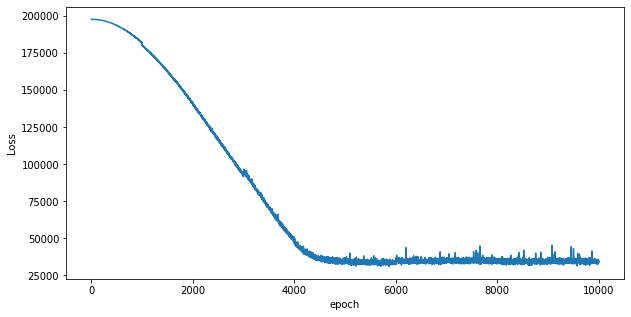

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(0, len(aggregated_losses)), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

# VALIDATION

In [ ]:
# Overfitting if: training loss << validation loss
# Underfitting if: training loss >> validation loss
# Just right if training loss ~ validation loss

with torch.no_grad():
    y_val = model(tensor_validation_categorical_data, tensor_validation_numerical_data)
    validation_loss = torch.sqrt(loss_function(y_val.squeeze(), tensor_validation_output))
print("Validation loss: ", str(validation_loss.item()))
print("Train Loss VS Validation loss: ", round(1 - aggregated_losses[len(aggregated_losses) - 1].item() / validation_loss.item(), 2) * 100)

Validation loss:  51240.125
Train Loss VS Validation loss:  33.0


# PREDICTION

In [ ]:
# To remove overfitting
#   Cross-validation: use your initial training data to generate multiple mini train-test splits.
#   Remove features: removing irrelevant input features or aggregate them 
#   Early stopping: stopping the training process before the learner degradates.
#   Regularization: adds a penalty as model complexity increases
#   Ensembling: machine learning methods for combining predictions from multiple separate models. 

In [ ]:
# Make predictions
with torch.no_grad():
    tensor_test_categorical_data = tensor_test_categorical.to(device)
    tensor_test_numerical_data = tensor_test_numerical.to(device)
    y_pred = model(tensor_test_categorical_data, tensor_test_numerical_data)

In [ ]:
submission_df = pd.DataFrame(y_pred, columns=['SalePrice']).astype("float")

submission_df = pd.concat([original_test_df, submission_df], axis=1)

submission_df = submission_df[['Id', 'SalePrice']]

submission_df

In [ ]:
from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TEST xgboost


In [ ]:
x_train = pd.get_dummies(train_df.drop('Source', axis=1))
y_train = train_output_df

space = {'n_estimators':hp.quniform('n_estimators', 1000, 4000, 100),
         'gamma':hp.uniform('gamma', 0.01, 0.05),
         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.025),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
         'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'gamma': params['gamma'],
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'colsample_bylevel': params['colsample_bylevel'],
             'reg_lambda': params['reg_lambda']}
    
    xb_a= xgb.XGBRegressor(**params)
    score = cross_val_score(xb_a, x_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

In [ ]:
best = fmin(fn=objective, space=space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [05:09<00:00, 15.50s/it, best loss: 1126016074.0472274]


In [ ]:
print(print(json.dumps(best, indent=4, sort_keys=True)))

{
    "colsample_bylevel": 0.7490854863915007,
    "colsample_bytree": 0.6970036766353755,
    "gamma": 0.03622174593328547,
    "learning_rate": 0.015737761891183078,
    "max_depth": 4.0,
    "n_estimators": 2100.0,
    "reg_lambda": 15.967977815448439,
    "subsample": 0.8376277427515022
}
None


In [ ]:
xb_b = xgb.XGBRegressor(
  random_state=0,
  n_estimators=int(best['n_estimators']),
  colsample_bytree= best['colsample_bytree'],
  gamma= best['gamma'],
  learning_rate= best['learning_rate'],
  max_depth= int(best['max_depth']),
  subsample= best['subsample'],
  colsample_bylevel= best['colsample_bylevel'],
  reg_lambda= best['reg_lambda']
)

xb_b.fit(x_train, y_train)

[12:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.7490854863915007, colsample_bynode=1,
             colsample_bytree=0.6970036766353755, gamma=0.03622174593328547,
             importance_type='gain', learning_rate=0.015737761891183078,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=15.967977815448439,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8376277427515022, verbosity=1)

In [ ]:
x_test = pd.get_dummies(test_df.drop('Source', axis=1))
preds = xb_b.predict(x_test)

In [ ]:
submission_df = pd.DataFrame({'Id': original_test_df.Id,'SalePrice': preds})

In [ ]:
from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>